In [1]:
import torch 
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.online.models import UNet as UNet_online
from smartem.segmentation import segmenter
import h5py
from tqdm import tqdm
from skimage import measure
import pyvoi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_74239/286197016.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"

device = torch.device("cuda:0")

em2mb_model_us = UNet_offline.UNet(1,2)
em2mb_model_core = UNet_online.UNet(1,2)
em2mb_path_us = "../../pretrained_models/em2mb_best.pth"
em2mb_path_core = "../../pretrained_models/em2mb_best_core.pth"

valid_dwts = [25, 50, 75, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]

In [24]:
Iseg_mit = segmenter.Segmenter(em2mb_path_us, segmenter_function = measure.label, device=device)
Iseg_mit.set_model(model_class=em2mb_model_us)

Iseg_core = segmenter.Segmenter(em2mb_path_core, segmenter_function = measure.label, device=device)
Iseg_core.set_model(model_class=em2mb_model_core)

segmenting regions...:   0%|          | 0/18 [00:00<?, ?it/s]

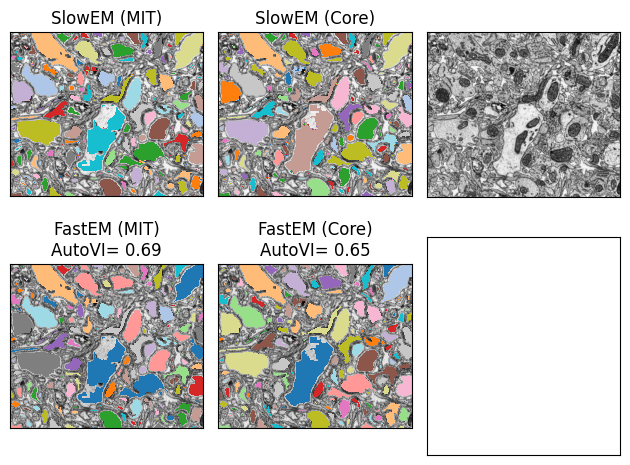

segmenting regions...: 100%|██████████| 18/18 [04:30<00:00, 15.01s/it]


In [21]:
data_auto_voi = []
data_dt = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for idx_reg, reg in enumerate(tqdm(f.keys(), desc="segmenting regions...")):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]
        slow_em = group[f"{slowest_dwt}/im"][()]

        sdt_labels_mit = Iseg_mit.get_labels(slow_em)
        sdt_labels_core = Iseg_core.get_labels(slow_em)

        for idx_dwt, dwt in enumerate(dwts):
            em = group[f"{dwt}/im"][()]

            labels_mit = Iseg_mit.get_labels(em)
            labels_core = Iseg_core.get_labels(em)

            # Compute VI
            voi_gt_mit = pyvoi.VI(sdt_labels_mit.flatten(), labels_mit.flatten())[0].item()
            voi_gt_core = pyvoi.VI(sdt_labels_core.flatten(), labels_core.flatten())[0].item()

            data_auto_voi.append(voi_gt_mit)
            data_dt.append(dwt)
            data_methods.append(f"FusedEM2MB trained @ MIT")

            data_auto_voi.append(voi_gt_core)
            data_dt.append(dwt)
            data_methods.append(f"FusedEM2MB from Core")

            if idx_reg == 0 and idx_dwt == 0:
                sdt_labels_mit_masked = np.ma.masked_array(sdt_labels_mit, mask = labels_mit==0)
                sdt_labels_core_masked = np.ma.masked_array(sdt_labels_core, mask = labels_core==0)

                labels_mit_masked = np.ma.masked_array(labels_mit, mask = labels_mit==0)
                labels_core_masked = np.ma.masked_array(labels_core, mask = labels_core==0)

                fig, axs = plt.subplots(ncols=3, nrows=2)
                axs[0,0].imshow(slow_em, cmap='gray')
                axs[0,0].imshow(sdt_labels_mit_masked % 20, cmap='tab20')
                axs[0,0].set_title("SlowEM (MIT)")

                axs[0,1].imshow(slow_em, cmap='gray')
                axs[0,1].imshow(sdt_labels_core_masked  % 20, cmap='tab20')
                axs[0,1].set_title("SlowEM (Core)")

                axs[0,2].imshow(slow_em, cmap='gray')

                axs[1,0].imshow(em, cmap='gray')
                axs[1,0].imshow(labels_mit_masked % 20, cmap='tab20')
                axs[1,0].set_title(f"FastEM (MIT)\nAutoVI={voi_gt_mit : .2f}")

                axs[1,1].imshow(em, cmap='gray')
                axs[1,1].imshow(labels_core_masked  % 20, cmap='tab20')
                axs[1,1].set_title(f"FastEM (Core)\nAutoVI={voi_gt_core : .2f}")

                for ax in axs.flatten():
                    ax.set_xticks([])
                    ax.set_yticks([])

                fig.tight_layout()

                plt.show()


data = {"Method": data_methods, "VoI from Slow Dwell Time Segmentation": data_auto_voi, "Dwell Time (ns)": data_dt}
df = pd.DataFrame(data=data)

<Axes: xlabel='Dwell Time (ns)', ylabel='VoI from Slow Dwell Time Segmentation'>

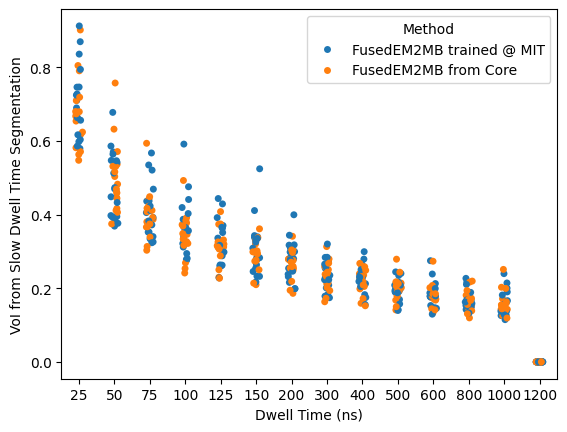

In [22]:
sns.stripplot(df, x="Dwell Time (ns)", y="VoI from Slow Dwell Time Segmentation", hue="Method")